In [ ]:
%%capture
%pip install transformers datasets black[jupyter]

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader, Dataset
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
from transformers import BertTokenizer

import matplotlib.pyplot as plt

This is a template of the notebook that you should complete and enrich with your own code.

First cells will be the same than the ones of the lab on text convolution.

# Data loading


In [ ]:
dataset = load_dataset("stanfordnlp/imdb", split="train")
print(dataset)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer(
        x["text"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    return x

🚧 **TODO** 🚧

Read the documentation about HuggingFace dataset and complete the code below.
You should:
- Shuffle the dataset
- For computational reasons, use only a total of **10000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only the column `input_ids`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [ ]:
n_samples = 10_000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle(seed=42)

# Select n_sampless samples
dataset = dataset.select(range(n_samples))

# Tokenize the dataset
dataset = dataset.map(lambda x: preprocessing_fn(x, tokenizer))

# Remove useless columns
dataset = dataset.select_columns(["input_ids"])

# Split the train and validation
dataset = dataset.train_test_split(test_size=0.2)

document_train_set = dataset["train"]
document_valid_set = dataset["test"]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# **Q2**
Let's extract the positive context words for each target word in the dataset.

In [ ]:
def extract_words_contexts(input_ids: list, R: int) -> tuple:
    """Extracts target words and their contexts from a list of input IDs."""

    targets = []  # ids of w
    contexts = []  # list of positive contexts (ids)

    N = len(input_ids)

    for i in range(N):
        left_context = input_ids[max(0, i - R) : i]  # words before w
        right_context = input_ids[i + 1 : min(N, i + R + 1)]  # words after w

        # Pad on the left
        while len(left_context) < R:
            left_context.insert(0, 0)  # 0 corresponds to [PAD]

        # Pad on the right
        while len(right_context) < R:
            right_context.append(0)

        context_window = left_context + right_context

        targets.append(input_ids[i])
        contexts.append(context_window)

    return targets, contexts

Let's inspect what the function produces on a given example.

In [ ]:
sample_ids = document_train_set[1]["input_ids"]
targets, contexts = extract_words_contexts(sample_ids[:20], 5)

targets

[6854,
 1010,
 2686,
 26468,
 2234,
 2041,
 2055,
 1996,
 2168,
 2051,
 2004,
 1996,
 12932,
 7738,
 1012,
 2029,
 2428,
 2404,
 1037,
 13675]

In [ ]:
contexts

[[0, 0, 0, 0, 0, 1010, 2686, 26468, 2234, 2041],
 [0, 0, 0, 0, 6854, 2686, 26468, 2234, 2041, 2055],
 [0, 0, 0, 6854, 1010, 26468, 2234, 2041, 2055, 1996],
 [0, 0, 6854, 1010, 2686, 2234, 2041, 2055, 1996, 2168],
 [0, 6854, 1010, 2686, 26468, 2041, 2055, 1996, 2168, 2051],
 [6854, 1010, 2686, 26468, 2234, 2055, 1996, 2168, 2051, 2004],
 [1010, 2686, 26468, 2234, 2041, 1996, 2168, 2051, 2004, 1996],
 [2686, 26468, 2234, 2041, 2055, 2168, 2051, 2004, 1996, 12932],
 [26468, 2234, 2041, 2055, 1996, 2051, 2004, 1996, 12932, 7738],
 [2234, 2041, 2055, 1996, 2168, 2004, 1996, 12932, 7738, 1012],
 [2041, 2055, 1996, 2168, 2051, 1996, 12932, 7738, 1012, 2029],
 [2055, 1996, 2168, 2051, 2004, 12932, 7738, 1012, 2029, 2428],
 [1996, 2168, 2051, 2004, 1996, 7738, 1012, 2029, 2428, 2404],
 [2168, 2051, 2004, 1996, 12932, 1012, 2029, 2428, 2404, 1037],
 [2051, 2004, 1996, 12932, 7738, 2029, 2428, 2404, 1037, 13675],
 [2004, 1996, 12932, 7738, 1012, 2428, 2404, 1037, 13675, 0],
 [1996, 12932, 7738, 1

# **Q3**
Applying the `extract_words_contexts` function to the dataset.

In [ ]:
def create_flatten_dataset_to_list(R: int):
    """Closure to create a flatten dataset to list function given a Radius R"""

    def flatten_dataset_to_list(dataset):
        dataset_list = []

        for row in dataset:
            targets, contexts = extract_words_contexts(row["input_ids"], R)
            dataset_list.extend(zip(targets, contexts))  # list(tuple(ids, list(int)))

        return dataset_list

    return flatten_dataset_to_list

# **Q4**
Applying the `flatten_dataset_to_list` on both splits

In [ ]:
RADIUS = 5
flatten_dataset_to_list = create_flatten_dataset_to_list(RADIUS)

contexts_train_set = flatten_dataset_to_list(document_train_set)
contexts_valid_set = flatten_dataset_to_list(document_valid_set)

# **Q5**  
Creating a Dataset to embed the flattened dataset.

In [ ]:
class ContextDataset(Dataset):
    def __init__(self, contexts_list):
        self.data = contexts_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        return self.data[idx]

In [ ]:
train_set = ContextDataset(contexts_train_set)
valid_set = ContextDataset(contexts_valid_set)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using Device {device}")

Using Device cuda


# **Q6**  
Creating the `collate_fn` to process the batches.

In [ ]:
def create_collate_fn(K, R, vocab_size):
    """closure for creating collate_fn given parameters K, R, and vocab_size."""

    def collate_fn(batch):
        word_id = []
        positive_context_ids = []
        negative_context_ids = []

        for sample in batch:
            target, positive_contexts = sample

            start_id = 100  # first 100 ids are unused
            neg_context_size = 2 * K * R

            negative_contexts = np.random.choice(
                np.arange(start_id, vocab_size), neg_context_size, replace=False
            )

            word_id.append(target)
            positive_context_ids.appwend(positive_contexts)
            negative_context_ids.append(negative_contexts)

        return {
            "word_id": torch.tensor(word_id, device=device),
            "positive_context_ids": torch.tensor(
                np.array(positive_context_ids), device=device
            ),
            "negative_context_ids": torch.tensor(
                np.array(negative_context_ids), device=device
            ),
        }

    return collate_fn

# **Q7**
Wrapping the Datasets in a DataLoader.

In [ ]:
# Parameters
R = 5
K = 2
VOCAB_SIZE = tokenizer.vocab_size
BATCH_SIZE = 32

collate_fn = create_collate_fn(K, R, VOCAB_SIZE)

train_loader = DataLoader(
    dataset=train_set, batch_size=BATCH_SIZE, collate_fn=collate_fn
)
valid_loader = DataLoader(
    dataset=valid_set, batch_size=BATCH_SIZE, collate_fn=collate_fn
)

# **Q8**  
Visualizing shapes of the batches.

In [ ]:
for i, batch in enumerate(train_loader):
    print(f"Iteration [{i}]")
    print(f"R={R} | K={K}")

    for key, val in batch.items():
        print(f"{key} shape: {val.shape}")

    if i == 2:
        break

Iteration [0]
R=5 | K=2
word_id shape: torch.Size([32])
positive_context_ids shape: torch.Size([32, 10])
negative_context_ids shape: torch.Size([32, 20])
Iteration [1]
R=5 | K=2
word_id shape: torch.Size([32])
positive_context_ids shape: torch.Size([32, 10])
negative_context_ids shape: torch.Size([32, 20])
Iteration [2]
R=5 | K=2
word_id shape: torch.Size([32])
positive_context_ids shape: torch.Size([32, 10])
negative_context_ids shape: torch.Size([32, 20])


# **Q9**
Creating the Word2Vec model.

In [ ]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.word_embed = nn.Embedding(vocab_size, embedding_dim)
        self.context_embed = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, word_id, context_ids):
        word_vec = self.word_embed(word_id)  # (B, d)
        context_vec = self.context_embed(context_ids)  # (B, N, d) N: 2R or 2KR

        word_vec = word_vec.unsqueeze(1)  # (B, d) -> (B, 1, d)
        context_vec = context_vec.transpose(1, 2)  # (B, N, d) -> (B, d, N)

        sim_score = torch.bmm(word_vec, context_vec).squeeze(1)  # (B, 1, N) -> (B, N)

        return torch.sigmoid(sim_score)

# **Q10**
Training the Word2Vec model.

In [ ]:
NUM_EPOCHS = 5
EMBEDDING_DIM = 100
LEARNING_RATE = 0.001

model = Word2Vec(VOCAB_SIZE, EMBEDDING_DIM).to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
losses = []
# Training loop
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0

    with tqdm(
        train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"
    ) as tepoch:
        for batch in tepoch:
            word_id = batch["word_id"].to(device)
            positive_context_ids = batch["positive_context_ids"].to(device)
            negative_context_ids = batch["negative_context_ids"].to(device)

            # Forward pass
            pos_probs = model(word_id, positive_context_ids)
            neg_probs = model(word_id, negative_context_ids)

            # calculate loss
            loss = loss_function(pos_probs, torch.ones_like(pos_probs)) + loss_function(
                neg_probs, torch.zeros_like(neg_probs)
            )

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    # Compute average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} | Average Loss: {avg_epoch_loss:.4f}")
    losses.append(avg_epoch_loss)

Epoch 1/5:   0%|          | 0/51593 [00:00<?, ?batch/s]

Epoch 1/5 | Average Loss: 2.3769


Epoch 2/5:   0%|          | 0/51593 [00:00<?, ?batch/s]

Epoch 2/5 | Average Loss: 0.8012


Epoch 3/5:   0%|          | 0/51593 [00:00<?, ?batch/s]

Epoch 3/5 | Average Loss: 0.6322


Epoch 4/5:   0%|          | 0/51593 [00:00<?, ?batch/s]

Epoch 4/5 | Average Loss: 0.5725


Epoch 5/5:   0%|          | 0/51593 [00:00<?, ?batch/s]

Epoch 5/5 | Average Loss: 0.5441


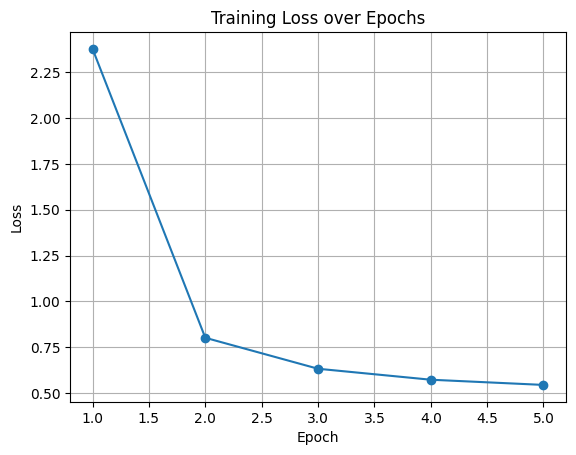

In [ ]:
# Plot the loss
plt.plot(range(1, NUM_EPOCHS + 1), losses, marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid()
plt.show()

# **Q11**  
Evaluating the model.

In [ ]:
model.eval()
correct = 0
total = 0
# Evaluation loop
with torch.no_grad():
    for batch in valid_loader:
        word_id = batch["word_id"]
        pos_context = batch["positive_context_ids"]
        neg_context = batch["negative_context_ids"]

        pos_scores = model(word_id, pos_context)
        neg_scores = model(word_id, neg_context)

        pred = torch.cat((pos_scores, neg_scores), dim=1)

        real = torch.cat(
            (torch.ones_like(pos_scores), torch.zeros_like(neg_scores)), dim=1
        )

        predicted_labels = (pred > 0.5).float()

        correct += (predicted_labels == real).sum().item()
        total += real.numel()

accuracy = correct / total

print(f"Model Accuracy: {accuracy * 100:.2f}")

Model Accuracy: 90.30


# **Q12**
Saving the model.

In [ ]:
def save_model(model, d, R, K, B, E):
    filename = f"model_dim-{d}_radius-{R}_ratio-{K}-batch-{B}-epoch-{E}.ckpt"
    torch.save(model.state_dict(), filename)
    print(f"Model saved as {filename}")


save_model(model, EMBEDDING_DIM, R, K, BATCH_SIZE, NUM_EPOCHS)

Model saved as model_dim-100_radius-5_ratio-2-batch-32-epoch-5.ckpt
